In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    CropForegroundd,
    RandFlipd,
    NormalizeIntensityd,
    RandGaussianNoised,
    Compose
)
from monai.utils import first
from rich import print
from rich.console import Console
from brain_tumor_segmentation.config import PROCESSED_DATA_DIR

console = Console()

# Function to plot slices dynamically
def plot_slices(original, transformed, title, slice_axis=2):
    """
    Plots the middle slice from a 3D volume for visualization.

    :param original: Original image array (H, W, D)
    :param transformed: Transformed image array (H, W, D)
    :param title: Title of the transformed image
    :param slice_axis: Axis to visualize (0 = Axial, 1 = Coronal, 2 = Sagittal)
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    mid_slice = original.shape[slice_axis] // 2  # Dynamically get the middle slice
    
    if slice_axis == 0:  # Axial View
        axes[0].imshow(original[mid_slice, :, :], cmap="gray")
        axes[1].imshow(transformed[mid_slice, :, :], cmap="gray")
    elif slice_axis == 1:  # Coronal View
        axes[0].imshow(original[:, mid_slice, :], cmap="gray")
        axes[1].imshow(transformed[:, mid_slice, :], cmap="gray")
    else:  # Sagittal View
        axes[0].imshow(original[:, :, mid_slice], cmap="gray")
        axes[1].imshow(transformed[:, :, mid_slice], cmap="gray")

    axes[0].set_title("Original Image")
    axes[1].set_title(title)
    plt.show()

2025-02-17 10:01:07.967 | INFO     | brain_tumor_segmentation.config:<module>:11 - PROJ_ROOT path is: /home/cepa995/workspace/brain-tumor-segmentation


In [2]:
# Load image and label using nibabel
image_path = os.path.join(PROCESSED_DATA_DIR, 'NIfTI', 'CPTAC-GBM', '00444', 'FLAIR', 'CPTAC-GBM_00444_FLAIR_resampled.nii.gz')
label_path = os.path.join(PROCESSED_DATA_DIR, 'NIfTI', 'CPTAC-GBM', '00444', 'CPTAC-GBM_00444_segmentation.nii.gz')

image = nib.load(image_path).get_fdata(dtype=np.float32)  # Load as float32
label = nib.load(label_path).get_fdata(dtype=np.float32)  # Convert label to float32

# Debug: Print dataset statistics
console.print("\n:mag: [bold green]Image Statistics[/]")
console.print(f"• Shape: {image.shape} (H, W, D)")
console.print(f"• Min: {image.min()}, Max: {image.max()}, Mean: {image.mean()}")

console.print("\n:mag: [bold green]Label Unique Values[/]:", np.unique(label))

🔍 Image Statistics

• Shape: (240, 240, 155) (H, W, D)

• Min: 0.0, Max: 1404.0, Mean: 55.591033935546875

🔍 Label Unique Values: [0. 1. 2. 4.]

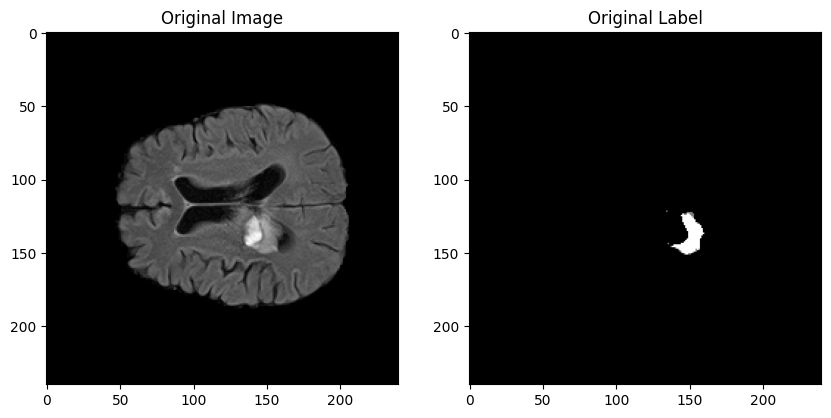

In [3]:
# Ensure MONAI-compatible shape (C, H, W, D)
image = np.expand_dims(image, axis=0)  # Add channel dim -> (1, H, W, D)
label = np.expand_dims(label, axis=0)  # Add channel dim -> (1, H, W, D)

# Visualize Original Image and Label
plot_slices(image[0], label[0], "Original Label", slice_axis=2)  # Default axial view

In [ ]:
# Convert to MONAI dictionary format
data = [{"images": image, "label": label}]

# Define transformations
roi = (32, 32, 32)  # Ensure it's compatible with (H, W, D)
transforms_list = [
    # CropForegroundd - Cropping Non-Informative Background
    # Purpose:
    # - Brain MRI scans contain a lot of empty black background.
    # - Tumors are small, and if the model sees too much background, it may struggle to focus on the tumor itself.
    # How It Works:
    # - Identifies the bounding box around the non-zero intensity pixels (brain tissue).
    # - Removes unnecessary empty space, improving data efficiency.
    # - Ensures the cropped region is divisible by the model input size (k_divisible).
    # Why It’s Useful for Brain Tumor Analysis?
    # - Reduces computational load by removing black background.
    # - Forces the model to focus only on the brain and tumor.
    # - Standardizes input sizes across different MRI scans.
    CropForegroundd(keys=["images", "label"], source_key="images", k_divisible=None),  # First test without constraints

    # RandFlipd - Randomly Flipping the Image
    # Purpose:
    # - Flipping helps generalization by mimicking real-world variability.
    # - While the human brain is symmetrical, tumors can appear anywhere, and flipping prevents overfitting to specific locations.
    # How It Works:
    # - Randomly flips the image across one or more axes (spatial_axis=0,1,2).
    # - Axial flip (spatial_axis=0) → Mirrors left/right brain hemispheres.
    # - Coronal flip (spatial_axis=1) → Mirrors front/back orientation.
    # - Sagittal flip (spatial_axis=2) → Mirrors left/right side of the head.
    # Why It’s Useful for Brain Tumor Analysis?
    # - Does not change anatomy (brain remains anatomically correct).
    # - Tumor contrast and shape remain unchanged.
    # - Helps the model learn spatially invariant features (not overfitting to one side of the brain).
    RandFlipd(keys=["images", "label"], prob=1.0, spatial_axis=0),  # Force flip along axial
    RandFlipd(keys=["images", "label"], prob=1.0, spatial_axis=1),  # Force flip along coronal
    RandFlipd(keys=["images", "label"], prob=1.0, spatial_axis=2),  # Force flip along sagittal
    
    # MRI scans often contain noise due to:
    #     - Scanner artifacts (magnetic field inhomogeneities)
    #     - Patient movement
    #     - Low signal-to-noise ratio (SNR)
    # Gaussian noise augmentation helps the model become more robust by forcing it to learn meaningful features despite noise.
    #RandGaussianNoised(keys=["images"], prob=1.0, mean=0.0, std=0.05),
    
    # NormalizeIntensityd - Standardizing Intensity
    # Purpose:
    # - MRI images vary in intensity due to scanner differences (GE, Siemens, Philips), acquisition protocols, and patient conditions.
    # - Normalizing intensity ensures the model learns consistent tissue contrasts, rather than being biased toward scanner-specific intensity distributions.
    # How It Works:
    # - Computes the mean and standard deviation of non-zero pixels.
    # - Applies Z-score normalization
    # Why It’s Useful for Brain Tumor Analysis?
    # - Ensures consistent contrast across different MRI scans.
    # - Prevents the model from overfitting to scanner differences.
    # - Helps in detecting tumors based on structure, not raw intensity values.
    NormalizeIntensityd(keys="images", nonzero=True, channel_wise=True),
]

/home/cepa995/workspace/brain-tumor-segmentation/venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


🛠 Applying Transformation 1: CropForegroundd

✅ Image Shape After Transformation:
torch.Size([1, 144, 168, 140])

✅ Label Shape After Transformation:
torch.Size([1, 144, 168, 140])

🔍 Updated Image Stats: min = metatensor(0.) , max = metatensor(1404.) , mean = metatensor(146.5410)

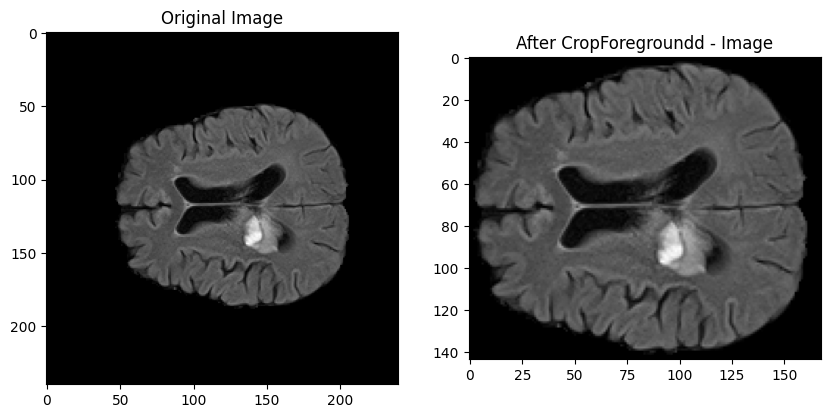

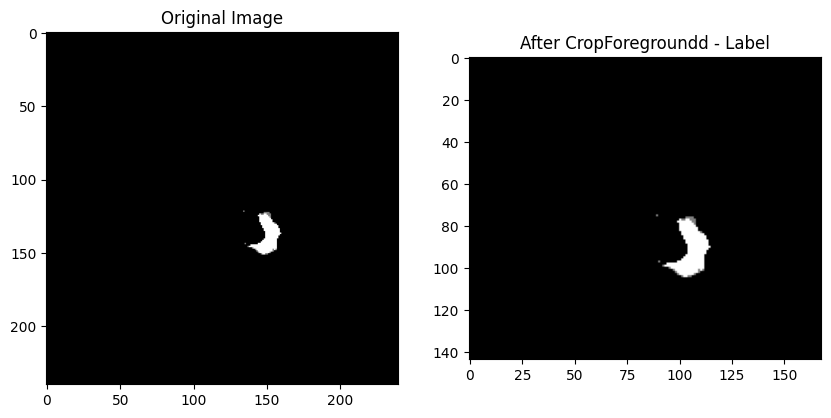

🛠 Applying Transformation 2: RandFlipd

✅ Image Shape After Transformation:
torch.Size([1, 144, 168, 140])

✅ Label Shape After Transformation:
torch.Size([1, 144, 168, 140])

🔍 Updated Image Stats: min = metatensor(0.) , max = metatensor(1404.) , mean = metatensor(146.5410)

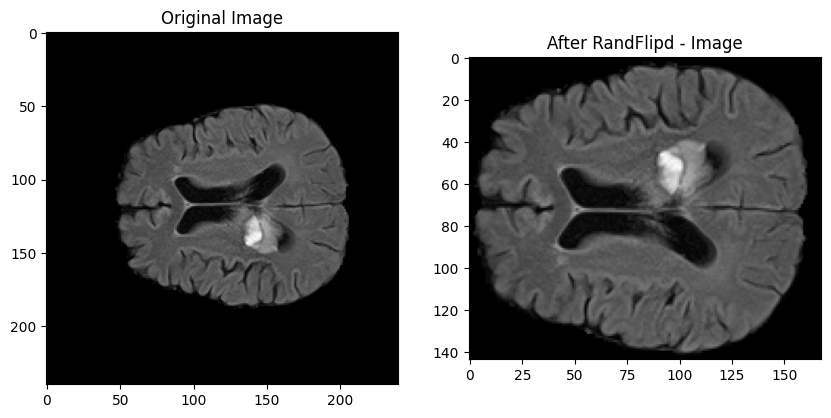

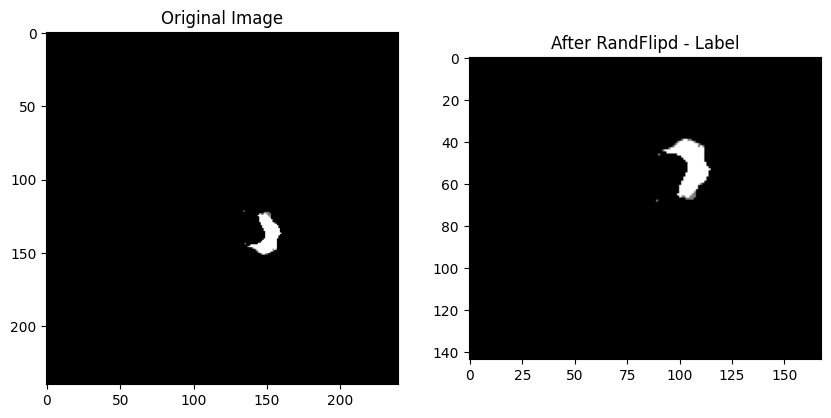

🛠 Applying Transformation 3: RandFlipd

✅ Image Shape After Transformation:
torch.Size([1, 144, 168, 140])

✅ Label Shape After Transformation:
torch.Size([1, 144, 168, 140])

🔍 Updated Image Stats: min = metatensor(0.) , max = metatensor(1404.) , mean = metatensor(146.5410)

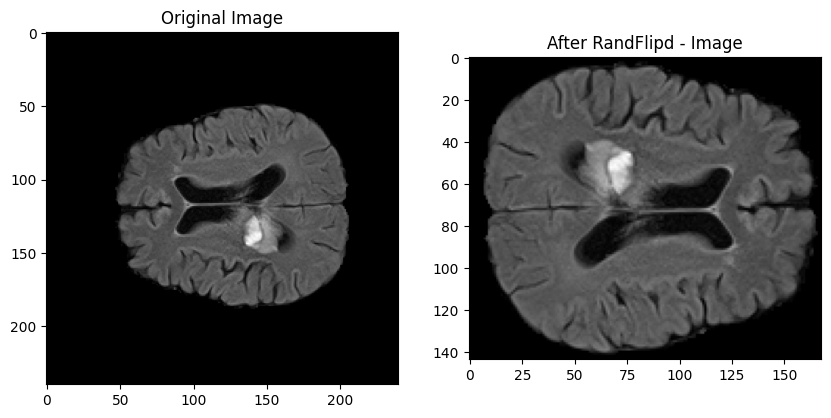

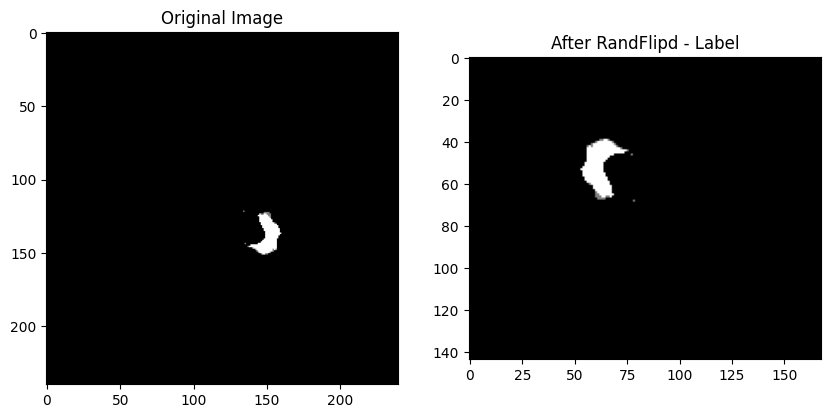

🛠 Applying Transformation 4: RandFlipd

✅ Image Shape After Transformation:
torch.Size([1, 144, 168, 140])

✅ Label Shape After Transformation:
torch.Size([1, 144, 168, 140])

🔍 Updated Image Stats: min = metatensor(0.) , max = metatensor(1404.) , mean = metatensor(146.5410)

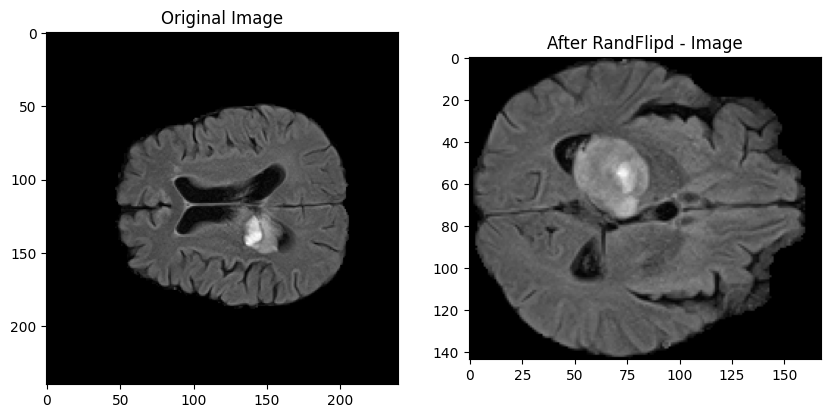

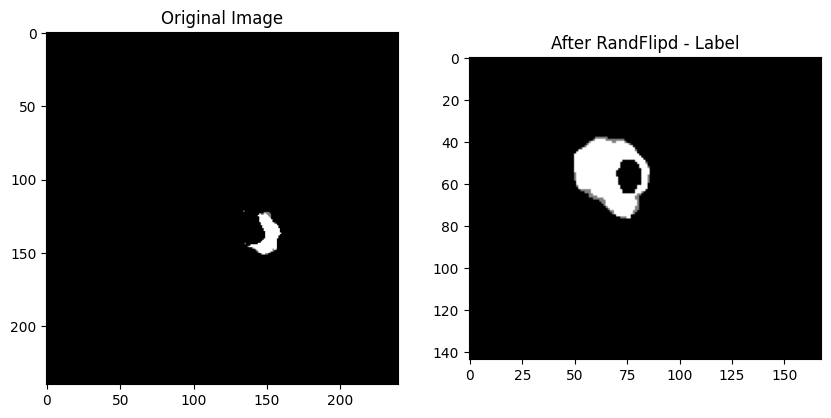

🛠 Applying Transformation 5: RandGaussianNoised

✅ Image Shape After Transformation:
torch.Size([1, 144, 168, 140])

✅ Label Shape After Transformation:
torch.Size([1, 144, 168, 140])

🔍 Updated Image Stats: min = metatensor(-0.0366) , max = metatensor(1404.0183) , mean = metatensor(146.5410)

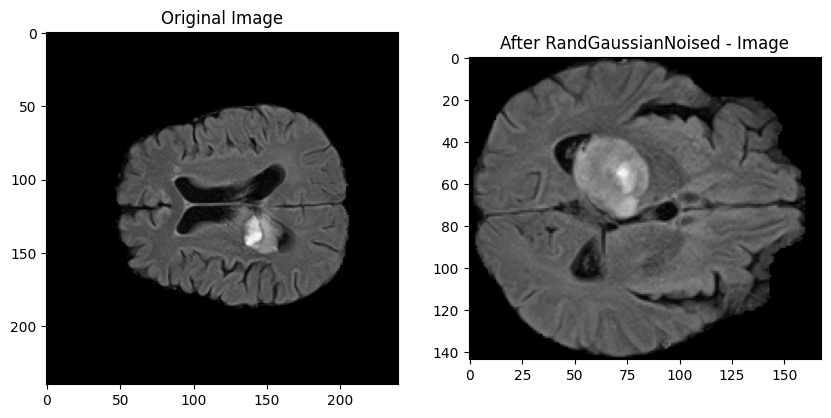

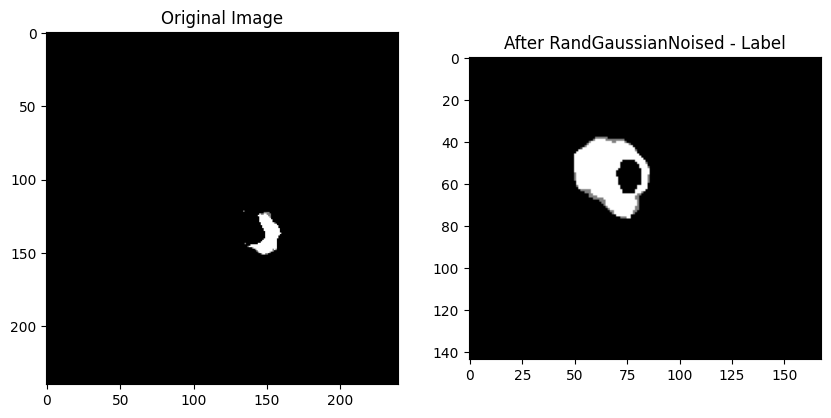

🛠 Applying Transformation 6: NormalizeIntensityd

✅ Image Shape After Transformation:
torch.Size([1, 144, 168, 140])

✅ Label Shape After Transformation:
torch.Size([1, 144, 168, 140])

🔍 Updated Image Stats: min = metatensor(-0.8690) , max = metatensor(7.4549) , mean = metatensor(9.2268e-09)

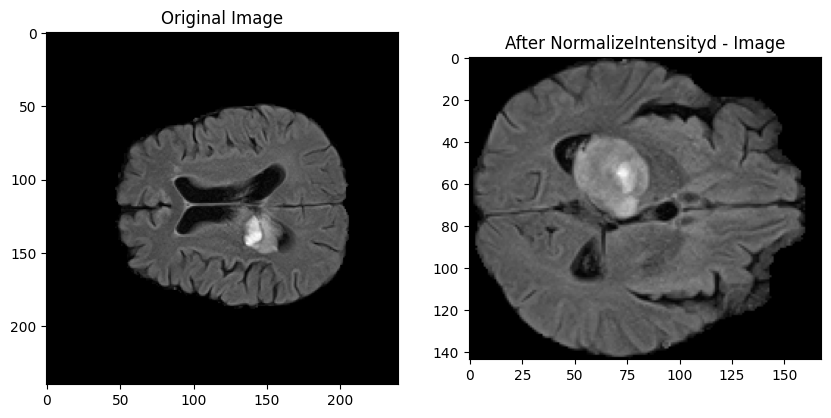

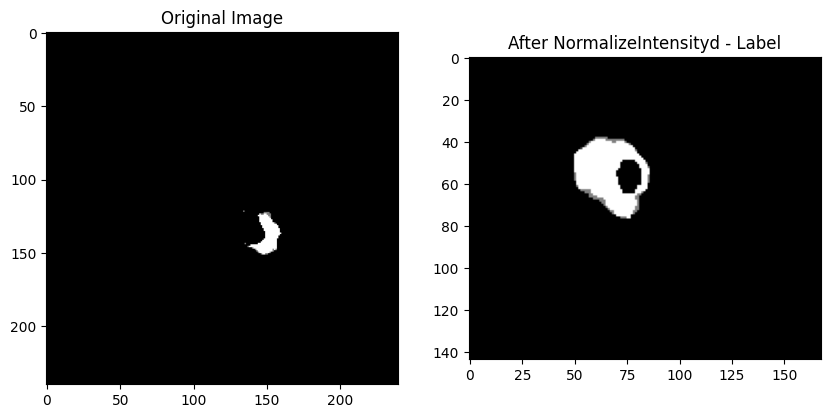

In [5]:
# Apply transformations step-by-step and visualize
transformed_data = data[0]  # Keep a copy of original data

for idx, transform in enumerate(transforms_list):
    console.print(f"\n:hammer_and_wrench: [yellow]Applying Transformation {idx + 1}: {transform.__class__.__name__}[/]\n")
    
    transformed_data = transform(transformed_data)  # Apply transformation
    
    # Debug print
    console.print(":white_check_mark: [green]Image Shape After Transformation[/]:", transformed_data["images"].shape)
    console.print(":white_check_mark: [green]Label Shape After Transformation[/]:", transformed_data["label"].shape)
    console.print(":mag: [bold green]Updated Image Stats[/]: min =", transformed_data["images"].min(), ", max =", transformed_data["images"].max(), ", mean =", transformed_data["images"].mean())

    # Visualize after each transformation
    plot_slices(image[0], transformed_data["images"][0], f"After {transform.__class__.__name__} - Image", slice_axis=2)
    plot_slices(label[0], transformed_data["label"][0], f"After {transform.__class__.__name__} - Label", slice_axis=2)

🚀 Final Transformed Image and Label

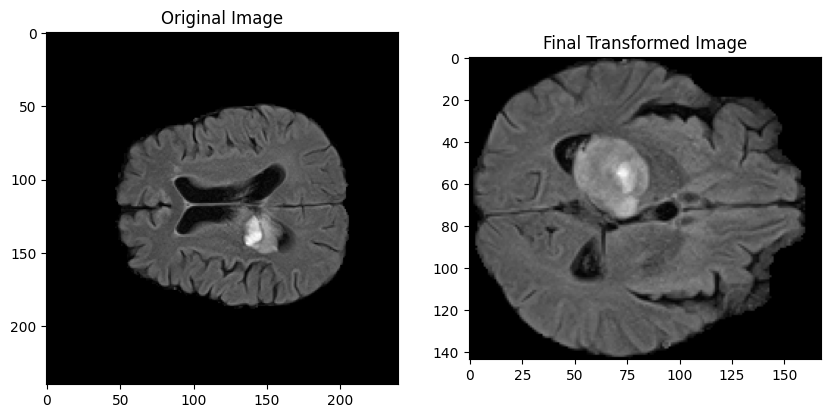

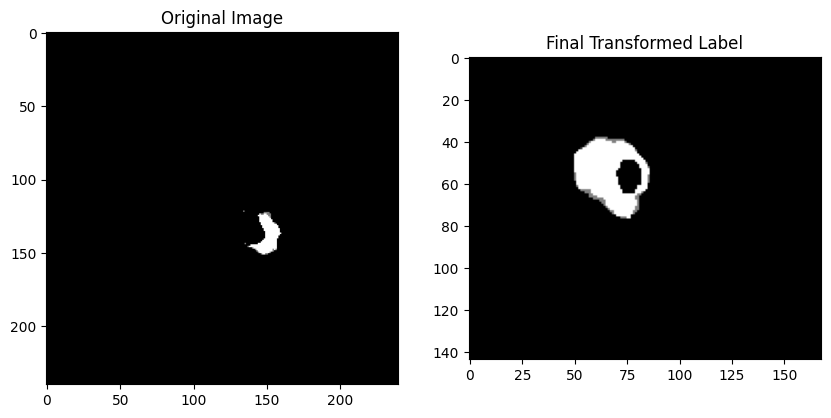

In [6]:
# Final transformed image and label
final_image = transformed_data["images"][0]
final_label = transformed_data["label"][0]

# Show final result
console.print("\n🚀 [bold cyan]Final Transformed Image and Label[/]\n")
plot_slices(image[0], final_image, "Final Transformed Image", slice_axis=2)
plot_slices(label[0], final_label, "Final Transformed Label", slice_axis=2)